# Machine Learning - SVM

* SVM aplicado na classificação de músicas do Spotify.
* O SVM será utilizado para criação de classificador que identifica possíveis músicas que um usuário poderia gostar.
* Treinamento do algoritmo, validação do modelo e tunning dos parâmetros do SVM.

### Carregando Bibliotecas

In [1]:
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import svm
from matplotlib import style

### Carregamento da base de dados
- Informações das Features da Base de dados<br>
https://developer.spotify.com/web-api/get-audio-features/

In [2]:
df = pd.read_csv('data.csv', encoding='utf-8')
df.head()

,id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


### Análise Exploratória dos Dados (EDA)

Verificando a existência de valores nulos na base

In [3]:
df.isnull().sum()

id                  0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
target              0
song_title          0
artist              0
dtype: int64

*Nenhuma feature possui valor nulo.*

Resumo estatístico dos dados numéricos.

In [4]:
df.describe()

,id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2017.000000,2017.000000,2017.000000,2.017000e+03,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,1008.000000,0.187590,0.618422,2.463062e+05,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815,0.505702
std,582.402066,0.259989,0.161029,8.198181e+04,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195,0.500091
min,0.000000,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000
25%,504.000000,0.009630,0.514000,2.000150e+05,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000,0.000000
50%,1008.000000,0.063300,0.631000,2.292610e+05,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000,1.000000
75%,1512.000000,0.265000,0.738000,2.703330e+05,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000,1.000000
max,2016.000000,0.995000,0.984000,1.004627e+06,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


Plota a dispersão dos dados das features **danceability** e **acousticness**.

<IPython.core.display.Javascript object>


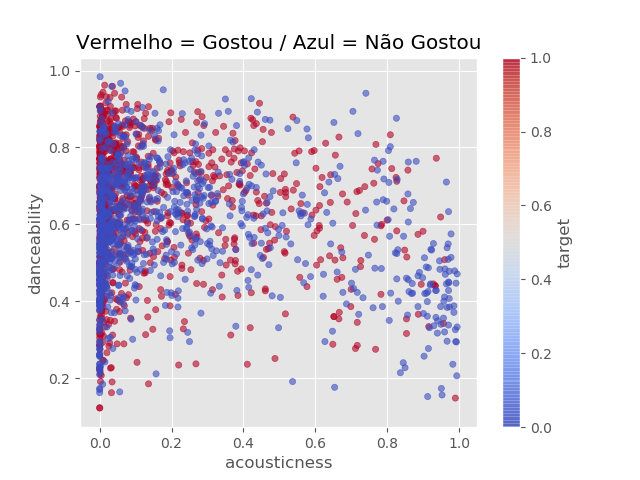

In [5]:
%matplotlib notebook
style.use('ggplot')
df.plot(x='acousticness', y='danceability', title='Vermelho = Gostou / Azul = Não Gostou' ,c='target', kind='scatter', alpha=0.6, colormap='coolwarm')

*É possível notar que a concentração de gostei no atributo 'acousticness' é maior até o valor de 0,4 e após isso os dados são mais esparsos e quanto ao 'danceability' tem se uma maior concentração de 0.5 até ~0,9. Relacionando as 2 variáveis, quanto menor o 'acousticness' e com 'danceability' mediano, maior as chances do usuário gostar da música.*

Plota a dispersão dos dados das features **tempo** e **valence**.

<IPython.core.display.Javascript object>


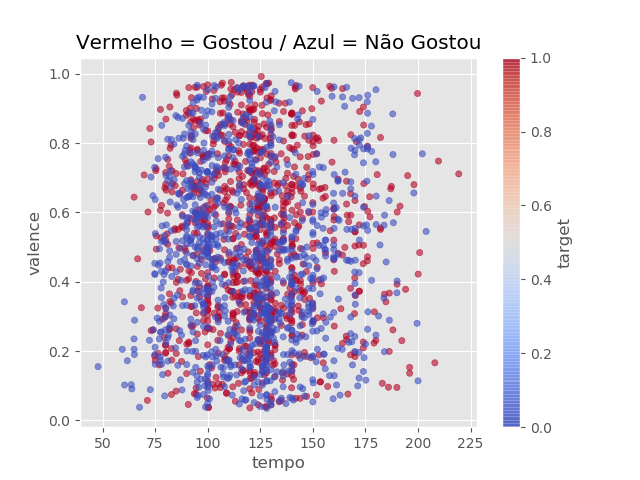

In [6]:
%matplotlib notebook
style.use('seaborn-colorblind')
df.plot(x='tempo', y='valence', title = 'Vermelho = Gostou / Azul = Não Gostou', c='target', kind='scatter', alpha=0.6, colormap='coolwarm')

*A maioria das músicas estão entre 100 a 150 BPM. A partir do gráfico não é possível identificar se o fator tempo e valence influenciam no gosto devido aos dados estarem dispersos, porém com uma leve concentração de gostei entre o 'tempo' 100 e 150.*

Plota a dispersão dos dados das features **tempo** e **speechiness**.

<IPython.core.display.Javascript object>


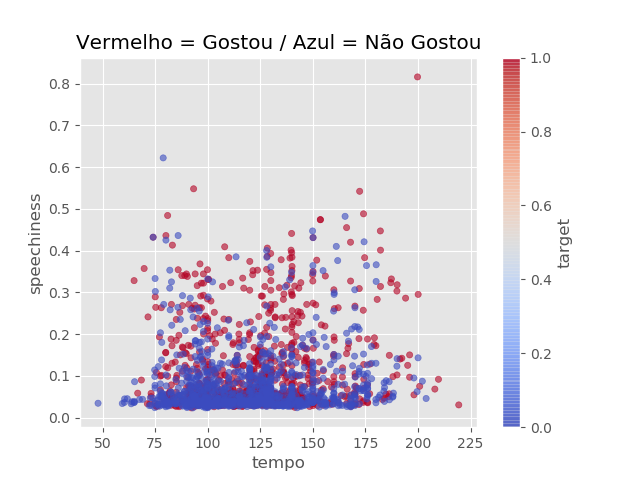

In [7]:
%matplotlib notebook
style.use('seaborn-colorblind')
df.plot(x='tempo', y='speechiness', title = 'Vermelho = Gostou / Azul = Não Gostou', c='target', kind='scatter', alpha=0.6, colormap='coolwarm')

*É possível notar que quanto menor o 'speechiness' (menos vozes) e com 'tempo' (BPM) mediano, maior é a tendência do usuário gostar da música.*

Plota a dispersão dos dados das features **danceability** e **energy**.

<IPython.core.display.Javascript object>


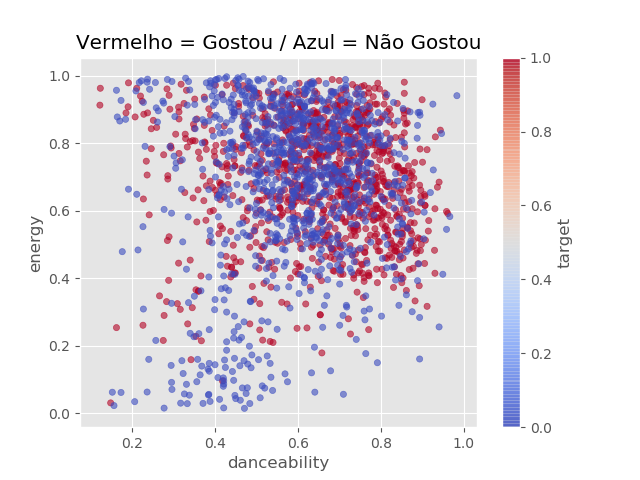

In [8]:
%matplotlib notebook
style.use('seaborn-colorblind')
df.plot(x='danceability', y='energy', title = 'Vermelho = Gostou / Azul = Não Gostou', c='target', kind='scatter', alpha=0.6, colormap='coolwarm')

*É possível notar que o usuário gosta mais de músicas com alta 'danceability' e 'energy' através da concentração de pontos no segundo quadrante.*

### Pré-Processamento dos dados

- Criando dataframe com os dados de saída (classes / target)<br>
*Como a base de dados inicial é formada tanto pelos dados de entrada quanto os dados de saída se torna necessário a criação de um dataframe apenas com os dados de saída para que possamos utilizá-lo no treinamento do modelo.*

In [9]:
target = df['target']
df.drop('target', axis=1, inplace = True)

- Removendo features<br>
*Criando e aplicando uma função para remoção de features. O parâmetro id e song_title são desnecessários para o treinamento de nosso modelo por não terem significância aparentemente.*

In [10]:
# Criando função para remover features
def remove_features(dataset, features_list):
    dataset.drop(columns=features_list, inplace=True)
    return 0

In [11]:
remove_features(df,['id', 'song_title'])

0

In [12]:
# Visualizando o dataset
df1 = df
df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,Junior Boys


Resumo das informações de características do dataframe.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 14 columns):
acousticness        2017 non-null float64
danceability        2017 non-null float64
duration_ms         2017 non-null int64
energy              2017 non-null float64
instrumentalness    2017 non-null float64
key                 2017 non-null int64
liveness            2017 non-null float64
loudness            2017 non-null float64
mode                2017 non-null int64
speechiness         2017 non-null float64
tempo               2017 non-null float64
time_signature      2017 non-null float64
valence             2017 non-null float64
artist              2017 non-null object
dtypes: float64(10), int64(3), object(1)
memory usage: 220.7+ KB


### Label Encoder

* Técnica para codificar valores categoricos em numéricos
* Um exemplo seria: a lista de cores: _(‘branco’,’preto’,’amarelo’,’vermelho’,'branco')_
* Após aplicar o LabelEncoder esta seria algo como __(1,2,3,4,1)__

In [14]:
from sklearn.preprocessing import LabelEncoder

*Instanciando e aplicando o Label Encoder*

In [15]:
enc = LabelEncoder()

inteiros = enc.fit_transform(df['artist'])

In [16]:
set(inteiros)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [17]:
df['artist_inteiros'] = inteiros

In [18]:
df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artist,artist_inteiros
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,Future,449
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,Childish Gambino,222
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,Future,449
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,Beach House,95
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,Junior Boys,628


In [19]:
remove_features(df, ['artist'])

0

*Um dos problemas do LabelEncoder é que ele cria índices para cada categoria sendo que em modelos onde se leva em consideração a distância, um valor alto poderá ter maior influência do que os valores menores há não ser que esse label categórico tenha uma ordem que faça sentido, como, por exemplo, baixo, médio e alto.*

### One Hot Encoding

* Técnica usada para codificar valores categóricos em númericos.
* Cria uma matriz de presença.
* Resolve o problema __ordenação__ nos dados gerados pelo LabelEncoder.

In [20]:
# Importa o pacote OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

In [21]:
# Instancia um objeto do tipo OnehotEncoder
ohe = OneHotEncoder()

In [22]:
df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artist_inteiros
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,449
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,222
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,449
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,95
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,628


In [23]:
# Dataframe em array
df.values

array([[1.02000e-02, 8.33000e-01, 2.04600e+05, ..., 4.00000e+00,
        2.86000e-01, 4.49000e+02],
       [1.99000e-01, 7.43000e-01, 3.26933e+05, ..., 4.00000e+00,
        5.88000e-01, 2.22000e+02],
       [3.44000e-02, 8.38000e-01, 1.85707e+05, ..., 4.00000e+00,
        1.73000e-01, 4.49000e+02],
       ...,
       [8.57000e-03, 6.37000e-01, 2.07200e+05, ..., 4.00000e+00,
        4.70000e-01, 9.47000e+02],
       [1.64000e-03, 5.57000e-01, 1.85600e+05, ..., 4.00000e+00,
        6.23000e-01, 1.24200e+03],
       [2.81000e-03, 4.46000e-01, 2.04520e+05, ..., 4.00000e+00,
        4.02000e-01, 1.32000e+02]])

In [24]:
# Transforma em array numpy o dataset.
df_array = df.values

In [25]:
# Numero de Linhas
num_rows = df_array.shape[0]

In [26]:
df_array

array([[1.02000e-02, 8.33000e-01, 2.04600e+05, ..., 4.00000e+00,
        2.86000e-01, 4.49000e+02],
       [1.99000e-01, 7.43000e-01, 3.26933e+05, ..., 4.00000e+00,
        5.88000e-01, 2.22000e+02],
       [3.44000e-02, 8.38000e-01, 1.85707e+05, ..., 4.00000e+00,
        1.73000e-01, 4.49000e+02],
       ...,
       [8.57000e-03, 6.37000e-01, 2.07200e+05, ..., 4.00000e+00,
        4.70000e-01, 9.47000e+02],
       [1.64000e-03, 5.57000e-01, 1.85600e+05, ..., 4.00000e+00,
        6.23000e-01, 1.24200e+03],
       [2.81000e-03, 4.46000e-01, 2.04520e+05, ..., 4.00000e+00,
        4.02000e-01, 1.32000e+02]])

In [27]:
# Visualiza coluna de artista
df_array[:][:,13]

array([ 449.,  222.,  449., ...,  947., 1242.,  132.])

In [28]:
inteiros

array([ 449,  222,  449, ...,  947, 1242,  132])

In [29]:
# Transforma a matriz em uma dimensão
inteiros = inteiros.reshape(len(inteiros),1)

In [30]:
inteiros

array([[ 449],
       [ 222],
       [ 449],
       ...,
       [ 947],
       [1242],
       [ 132]])

In [31]:
# Criar as novas features a partir da matriz de presença
novas_features = ohe.fit_transform(inteiros)

C:\Users\edubr\Anaconda3\envs\data-science\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [32]:
# Imprime as novas features
novas_features

<2017x1343 sparse matrix of type '<class 'numpy.float64'>'
	with 2017 stored elements in Compressed Sparse Row format>

In [33]:
# Concatena as novas features ao array
df_array = np.concatenate([df_array, novas_features.toarray()], axis=1)

In [34]:
# Visualizando a quantidade de linhas e colunas da base
df_array.shape

(2017, 1357)

In [35]:
# Transforma em dataframe e visualiza as colunas
dataf = pd.DataFrame(df_array)

In [36]:
dataf.head()

,0,1,2,3,4,5,6,7,8,9,...,1347,1348,1349,1350,1351,1352,1353,1354,1355,1356
0,0.0102,0.833,204600.0,0.434,0.021900,2.0,0.1650,-8.795,1.0,0.4310,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.1990,0.743,326933.0,0.359,0.006110,1.0,0.1370,-10.401,1.0,0.0794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0344,0.838,185707.0,0.412,0.000234,2.0,0.1590,-7.148,1.0,0.2890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.6040,0.494,199413.0,0.338,0.510000,5.0,0.0922,-15.236,1.0,0.0261,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.1800,0.678,392893.0,0.561,0.512000,5.0,0.4390,-11.648,0.0,0.0694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Pandas Get_Dummies

Cria uma matriz de presença como feito com o One Hot Encoder.

In [39]:
df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,artist_inteiros
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,449
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,222
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,449
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,95
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,628


In [40]:
# Aplicando o método get_dummies na feature 'artist'.
df = pd.get_dummies(df1, columns=['artist'], prefix=['artist'])

KeyError: "None of [Index(['artist'], dtype='object')] are in the [columns]"

In [41]:
#Visualizando as 'features' criadas pelo get_dummies
df.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'artist_inteiros'],
      dtype='object')

In [42]:
df.dtypes

acousticness        float64
danceability        float64
duration_ms           int64
energy              float64
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
speechiness         float64
tempo               float64
time_signature      float64
valence             float64
artist_inteiros       int32
dtype: object

In [43]:
# Verificando valores nulos do dataframe
df.isnull().sum()

acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
artist_inteiros     0
dtype: int64

In [44]:
len(df.columns)

14